In [1]:
from keras.optimizers import *
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.utils import np_utils

import os,sys
import numpy as np
import pandas as pd
import cv2,time,glob,math
import matplotlib.pyplot as plt # plt 用于显示图片
from tqdm import tqdm #进度条

Using TensorFlow backend.


In [2]:
#设置一些基本参数
train_dir = 'train'
valid_dir = 'validation'
test_dir = 'test2'
nb_train_samples = sum([len(x) for _, _, x in os.walk(train_dir)])
nb_valid_samples = sum([len(x) for _, _, x in os.walk(valid_dir)])
nb_test_samples = sum([len(x) for _, _, x in os.walk(test_dir)])
nb_categories = 10
epochs = 5
labels = [" normal driving","texting - right","talking on the phone - right","texting - left",
          "talking on the phone - left","operating the radio",
          "drinking"," reaching behind","hair and makeup","talking to passenger"]

In [3]:
print nb_valid_samples

1828


In [4]:
from keras import backend as K
K.clear_session()

In [5]:
#set training parameters
model_name = 'VGG16'
fine_tune_layer = 0
optimizer = 'Adam'
learning_rate = 1e-3
augmentation = 'yes'
valid_set = 'p056_p066'
batch_size = 64
img_width, img_height = 224, 224

In [6]:
# 载入训练数据
def load_train(img_width, img_height):
    print('Read train images')
    start_time = time.time()
    X_train = np.zeros((nb_train_samples,img_width,img_height,3),dtype=np.uint8)
    Y_train = []
    X_train_id = []
    count = 0
    mean_pixel = [103.939, 116.779, 123.68]
    for i in tqdm(range(nb_categories)):
        path = os.path.join(train_dir,'c'+str(i), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = load_img(fl,False,target_size=(img_width,img_height))
            img = img_to_array(img)
            X_train[count][:] = img
            count = count + 1
            X_train_id.append(flbase)
            Y_train.append(i)
    print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
    X_train = X_train.astype('float32')
    for c in range(3):
        X_train[:, :, :, c] = X_train[:, :, :, c] - mean_pixel[c]
    Y_train = np.array(Y_train,dtype=np.uint8)
    Y_train = np_utils.to_categorical(Y_train, nb_categories) 
    print "X_train shape:", X_train.shape, "Y_train shape:",Y_train.shape
    return X_train, X_train_id,Y_train
X_train, X_train_id,Y_train = load_train(img_width,img_height)

# 载入验证数据
def load_validation(img_width, img_height, color_type=3):
    print('Read validation images')
    start_time = time.time()
    X_validation = np.zeros((nb_valid_samples,img_width,img_height,3),dtype=np.uint8)
    Y_validation = []
    X_validation_id = []
    count = 0
    mean_pixel = [103.939, 116.779, 123.68]
    for i in tqdm(range(nb_categories)):
        path = os.path.join('validation','c'+str(i), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = load_img(fl,False,target_size=(img_width,img_height))
            img = img_to_array(img)
            X_validation[count][:] = img
            count = count + 1
            X_validation_id.append(flbase)
            Y_validation.append(i)
    print('Read test data time: {} seconds'.format(round(time.time() - start_time, 2)))
    X_validation= X_validation.astype('float32')
    for c in range(3):
        X_train[:, :, :, c] = X_train[:, :, :, c] - mean_pixel[c]
    Y_validation = np.array(Y_validation,dtype=np.uint8)
    Y_validation = np_utils.to_categorical(Y_validation, nb_categories) 
    print "X_validation shape:", X_validation.shape, "Y_validation shape:",Y_validation.shape
    return X_validation, X_validation_id,Y_validation
X_validation, X_validation_id,Y_validation = load_validation(img_width,img_height)

  0%|          | 0/10 [00:00<?, ?it/s]

Read train images


100%|██████████| 10/10 [05:52<00:00, 33.77s/it]


Read train data time: 352.64 seconds


  0%|          | 0/10 [00:00<?, ?it/s]

X_train shape: (20596, 224, 224, 3) Y_train shape: (20596, 10)
Read validation images


100%|██████████| 10/10 [00:12<00:00,  1.18s/it]


Read test data time: 12.28 seconds
X_validation shape: (1828, 224, 224, 3) Y_validation shape: (1828, 10)


In [7]:
#对图像进行预处理
datagen = ImageDataGenerator(
    #rescale=1./255,   only need to substract mean, should not divide by 255
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1)
start_time = time.time()
datagen.fit(X_train)
print 'datagen fit time:{} seconds'.format(round(time.time() - start_time, 2))
train_generator = datagen.flow(X_train, Y_train, batch_size=batch_size)

#validation_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator()
validation_datagen.fit(X_validation)
validation_generator = validation_datagen.flow(X_validation, Y_validation, batch_size=batch_size)

datagen fit time:5.95 seconds


In [8]:
# build network on top of VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width,img_height, 3)) 
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) 
x = Dense(nb_categories, activation='softmax')(x) #10categories in our case

model = Model(inputs=base_model.input, outputs=x) #add top layers to VGG16
#set VGG16 layers to non-trainable, train top layers for a few epoches first
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
try:
    model.load_weights('model/VGG16toptrained.h5')
except:
    pass

In [ ]:
#训练top
model.fit_generator(train_generator,
                   steps_per_epoch=nb_train_samples//batch_size,epochs=1,
                   validation_data=validation_generator,
                   validation_steps=nb_valid_samples//batch_size)
model.save_weights('models/VGG16toptrained.h5')

In [10]:
#Fine tune 模型
#lock VGG16 layers, execpt the last CNN block. 
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:15]:
    layer.trainable = False

#recomplie the optimizer, use SGD at a low learning rate 
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#训练fine-tune模型
result = model.fit_generator(train_generator,
                   steps_per_epoch=nb_train_samples//batch_size,epochs=10,
                   validation_data=validation_generator,
                   validation_steps=nb_valid_samples//batch_size)
model.save_weights('models/VGG16fine_tuned.h5')

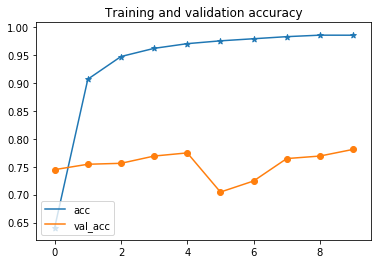

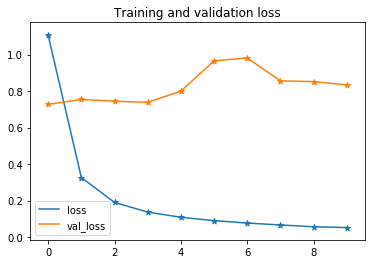

In [12]:
# 画图
def draw_gragh(result):
    plt.figure
    plt.plot(result.epoch,result.history['acc'],label="acc")
    plt.plot(result.epoch,result.history['val_acc'],label="val_acc")
    plt.scatter(result.epoch,result.history['acc'],marker='*')
    plt.scatter(result.epoch,result.history['val_acc'])
    plt.title('Training and validation accuracy')
    plt.legend(loc='lower left')
    plt.show()
    plt.figure
    plt.plot(result.epoch,result.history['loss'],label="loss")
    plt.plot(result.epoch,result.history['val_loss'],label="val_loss")
    plt.scatter(result.epoch,result.history['loss'],marker='*')
    plt.scatter(result.epoch,result.history['val_loss'],marker='*')
    plt.title('Training and validation loss')
    plt.legend(loc='lower left')
    plt.show()
draw_gragh(result)

## CAM 可视化

http://cnnlocalization.csail.mit.edu/

![](http://cnnlocalization.csail.mit.edu/framework.jpg)

$cam = (P-0.5)*w*output$

In [13]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def show_heatmap_image(model_show, weights_show):
    test_dir = 'test2/test/tests'
    image_files = glob.glob(os.path.join(test_dir,"*"))
    
    plt.figure(figsize=(12, 14))
    for i in tqdm(range(16)):
        plt.subplot(4, 4, i+1)
        img = cv2.imread(image_files[np.random.randint(len(image_files))])
        img = cv2.resize(img, (img_width, img_height))
        x = img.copy()
        x.astype(np.float32)
        out, predictions = model_show.predict(np.expand_dims(x, axis=0))
        predictions = predictions[0]
        out = out[0]
        
        pred_class = np.argmax(predictions)
        prob = predictions[pred_class]

        plt.title('c%d |%s| %.2f%%' % (pred_class , labels[pred_class], prob*100))
    
        cam = (prob - 0.5) * np.matmul(out, weights_show)
        cam = cam[:,:,pred_class]
        cam -= cam.min()
        cam /= cam.max()
        cam -= 0.2
        cam /= 0.8

        cam = cv2.resize(cam, (img_width, img_height))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam <= 0.2)] = 0

        out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

        plt.axis('off')
        plt.imshow(out[:,:,::-1])
print("done")

done


In [ ]:
weights = model.layers[21].get_weights()[0]
layer_output = model.layers[18].output
model2 = Model(model.input, [layer_output, model.output])
print("layer_output {0}".format(layer_output))
print("weights shape {0}".format(weights.shape))
show_heatmap_image(model2, weights)